<img src="https://github.com/huseyinelci2000/CustomerSegmentation/blob/master/Last/image/022.png?raw=true" width="100%">

# PART2: Supervised Learning

The purpose of this part is to train an algorithm to be able to find customers who will respond positive to a mailout campaign.
Did to apply Supervised Learning to investigate **MAILOUT-TRAIN** and **MAILOUT-TEST** datasets to predict a person became a customer or not of **the mail-order company following the campaign**.
The model of the algorithm is chosen with the help of learning curves and the best parameters.

---

<a id="1"></a>
# 1. Load the datas and Import Libraries

<a id="2"></a>
#### Summary about datas
The first step in this process is to read all the data from the different sources and check if this data have correct formats.

The data and sources to read in this project are four:

- **`Udacity_AZDIAS_052018.csv`**: <br>Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- **`Udacity_CUSTOMERS_052018.csv`**: <br>Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- **`Udacity_MAILOUT_052018_TRAIN.csv`**: <br>Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- **`Udacity_MAILOUT_052018_TEST.csv`**:<br> Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).


#### Choose Platform

In [1]:
use_colab=0  # When you want to use COLAB, assign 1 to use_colab
if use_colab==1:
    # Use Colab
    # Connecting with Google Drive
    from google.colab import drive
    drive.mount('/content/drive')  #Drive a baglanmak icin kullanilir
    #drive.flush_and_unmount()   #Drive dan baglantiyi kesmek icin kullanilir
    
    # Connecting to Path
    import sys
    sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks')
    
    # Install Some Library
    !pip install catboost
    !pip install category_encoders
    !pip install yellowbrick

    # Files with Path of Data from Colab
    attribute_file = '../content/drive/My Drive/Studying_Data/Last/data/DIAS Attributes - Values 2017.xlsx'
    train_file = '../content/drive/My Drive/Studying_Data/Last/data/mailout_train'
    test_file = '../content/drive/My Drive/Studying_Data/Last/data/mailout_test'
else:
    # Use data from My Local
    # Files with PATH
    attribute_file = '../Last/data/DIAS Attributes - Values 2017.xlsx'
    train_file = '../Last/data/mailout_train'
    test_file = '../Last/data/mailout_test'

##### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import sys
import os
from collections import Counter


import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,StratifiedKFold, cross_val_score, GridSearchCV

from xgboost.sklearn import XGBRegressor # Extreme Gradient Boosting
from sklearn.metrics import (roc_auc_score, fbeta_score, accuracy_score, precision_score,
                             recall_score, confusion_matrix, roc_curve, auc)

from imblearn.over_sampling import RandomOverSampler
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

import pickle

In [3]:
# Import my libraries for this project
from myutils.utils import (accu_cm,
                           attribute,
                           code_to_nan,
                           col_sync,
                           corr_drop,
                           drop,
                           encode_map_age,
                           encode_df_PJ,
                           encode_df_EIN,
                           encode_df_OWK,
                           N_unique,
                           pre_processing,
                           printS,
                           ROC_AUC_score,
                           report_missing_values,
                           row_missing_value)
seed = 29

D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


#### Loading data

In [4]:
# Loading data
train    = pd.read_csv(train_file, 
                        na_values=['X','XX', -1],
                        index_col=0)
test = pd.read_csv(test_file, 
                        na_values=['X','XX', -1], 
                        index_col=0)

train.set_index('LNR',inplace=True)
test.set_index('LNR',inplace=True)
test['RESPONSE']=0
response = train[['RESPONSE']]

display(train.head(3))
display(test.head(3))

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
1763,2.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,0.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1771,1.0,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
1776,1.0,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,NaN,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4


,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,RESPONSE
LNR,,,,,,,,,,,,,,,,,,,,,
1754,2.0,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,0.0,...,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4,0
1770,NaN,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,0.0,...,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4,0
1465,2.0,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,0.0,...,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4,0


In [5]:
rsize_train = train.shape[0]
rsize_test = test.shape[0]
print('Number of row size in Mailout Train :',rsize_train)
print('Number of row size in Mailout Test :',rsize_test)

Number of row size in Mailout Train : 42962
Number of row size in Mailout Test : 42833


In [6]:
df_mailout = pd.concat([train, test],sort=False)
rsize_df_mailout = df_mailout.shape[0]
print('Number of row size in Mailout Total :',rsize_df_mailout);

Number of row size in Mailout Total : 85795


---
<a id="2"></a>
# 2. Preprocesing the data for Supervised Modeling

##### Loading important columns come from Part-2-UnsupervisedLearing

In [7]:
# Loading important columns comes from Part-2-UnsupervisedLearing
imp_feat_list = list(pd.read_csv('../Last/imp_feat_list_part2.csv', index_col=0).index.values[0:70])

if 'customer' in imp_feat_list:
    imp_feat_list.remove('customer')
# Length of important columns list
print('Size of important columns comes from Part-2-UnsupervisedLearing:',len(imp_feat_list))

Size of important columns comes from Part-2-UnsupervisedLearing: 55


##### Merging Mailout Train and Mailout Test set

In [8]:
df_mailout = pd.concat([train, test],sort=False)
df_mailout.drop_duplicates(inplace=True)
rsize_df_mailout = df_mailout.shape[0]
print('Number of row size in Mailout Total :',rsize_df_mailout);

Number of row size in Mailout Total : 74391


##### Preprocessing of Merged Mailout Data set

In [9]:
# Preprocess of df_mailout
df_mailout, df_cols = pre_processing(df_mailout, attribute_file, 0.7, imp_feat_list)

display(df_mailout.head())
df_mailout.shape

Start Preprocessing...
 Implementing of Cols-Drop
 processing of get_dummies ...
 Processing of fill NaN with MEAN...
 Processing of scaling...


,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,...,SEMIO_LUST,SEMIO_PFLICHT,SEMIO_TRADV,SEMIO_VERT,VK_DISTANZ,VK_ZG11,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
1763,-0.305176,-1.167194,-0.433050,-0.763982,0.485227,-0.157002,0.114272,0.636437,0.656146,0.63119,...,0.949396,-0.058031,-1.228791,-0.699073,-0.776907,-0.851586,0.189967,-0.079994,0.852908,0.609333
1771,1.448848,0.149789,0.744528,-0.015198,-0.384358,-0.157002,0.114272,-0.403848,-1.159035,0.63119,...,0.337073,1.244039,0.168557,-0.172619,-0.776907,-0.851586,-1.475244,-0.079994,0.852908,-0.508188
1776,-0.305176,-0.903798,-0.668566,-1.512767,-0.384358,-1.152909,-0.929476,0.636437,0.656146,0.63119,...,0.949396,-1.360102,-1.228791,1.406744,-0.154693,-0.446750,0.189967,-0.079994,-1.172459,0.609333
1460,-0.305176,-1.693988,-0.904081,-0.015198,-0.166962,-0.157002,0.114272,0.636437,0.656146,0.63119,...,0.949396,0.593004,0.168557,-1.225527,2.023059,3.196773,0.189967,-0.079994,0.852908,0.609333
1783,-0.305176,-0.903798,-0.197535,-0.763982,2.731653,-1.152909,0.114272,0.636437,0.656146,0.63119,...,0.337073,0.593004,-0.530117,1.406744,-0.776907,-0.851586,0.189967,-0.079994,-1.172459,-0.508188


(74391, 56)

In [10]:
# Just Control list of important columns list
important_list_use = 1  
if important_list_use ==0:
    print(set(df_cols_from02) - set(df_mailout.columns.tolist()))
    print(set(df_mailout.columns.tolist()) - set(df_cols_from02))
else:
    print(set(imp_feat_list) - set(df_mailout.columns.tolist()))
    print(set(df_mailout.columns.tolist()) - set(imp_feat_list))
print(len(df_mailout.columns.tolist()))

set()
{'RESPONSE'}
56


#### Label encoding of Responce Column

In [11]:
# Looking for RESPONSE column
display(df_mailout['RESPONSE'].value_counts())

# Label  Encoding for RESPONSE column
df_mailout['RESPONSE'].replace({df_mailout['RESPONSE'].unique().tolist()[1]:1,
                                df_mailout['RESPONSE'].unique().tolist()[0]:0}, inplace=True)
df_mailout['RESPONSE'].value_counts()

-0.079994     73918
 12.500994      473
Name: RESPONSE, dtype: int64

0.0    73918
1.0      473
Name: RESPONSE, dtype: int64

#### Saving of Data After Preperation

In [12]:
# Separate Train and Test Dataframes from df_mailout

df_train = df_mailout.head(rsize_train) # Train file split from df_mailout
df_test = df_mailout.tail(rsize_test)   # Test file split from df_mailout

# Delete RESPONSE column which is created artificially to apply K-means algorithm
del df_test['RESPONSE']


In [13]:
df_train.to_csv('df_train.csv')
df_test.to_csv('df_test.csv')

---
<a id="1"></a>
# 3. Model Preperation

---

## Train-Test Split of Mailout-Train Data

In [14]:
df_train = pd.read_csv('df_train.csv')

In [15]:
df_train.shape

(42962, 57)

In [16]:
y = df_train['RESPONSE'].values # Target Value as array
X = df_train.drop('RESPONSE', axis=1).values   # Features as array

# Train - Test - Split Data 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=seed)

---

## Sampling for Imbalance Problem

<img src="https://github.com/huseyinelci2000/CustomerSegmentation/blob/master/Last/image/Imbalance_scales.jpg?raw=true" width="100%">

Distribution for **` target (RESPONSE) `** value in **Mailout-Train** data set like as sets of **Azdias** and **Customers**,  is **1.238%**. This tells us that there is an important **ImBalance** problem in this data set.<br>
To fix this situation, we will take samples in set of Mailout-Train. Let's try to implement with **RandomOverSampler** for to expand the data before implementation of ML algoritms.

In [17]:
ros = RandomOverSampler(sampling_strategy=0.2, random_state=seed)

X_ros, y_ros = ros.fit_resample(X_train, y_train)

print('Original dataset shape {}'.format(Counter(y_train)))
print('Resampled dataset shape {}'.format(Counter(y_ros)))


Original dataset shape Counter({0.0: 31866, 1.0: 355})
Resampled dataset shape Counter({0.0: 31866, 1.0: 6373})


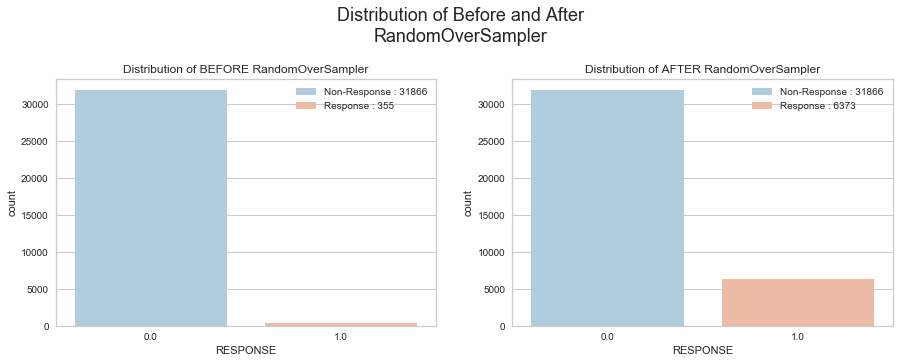

In [18]:
#Plot 
plot_y_train = pd.DataFrame(y_train,columns=['RESPONSE'])
plot_yros = pd.DataFrame(y_ros,columns=['RESPONSE'])

# Figure size-title for Plot 
fig, ax = plt.subplots(1, 2, figsize=(15,10))
fig.suptitle('Distribution of Before and After\nRandomOverSampler', fontsize=18)


# Plot for Distribution of Before RandomOverSampler
plt.subplot(221).set_title('Distribution of BEFORE RandomOverSampler')
sns.countplot(x="RESPONSE",
              hue="RESPONSE",
              data=plot_y_train,
              dodge=False,
              palette="RdBu_r")
plt.legend({"Non-Response : {}".format(Counter(y_train)[0]):0,
            "Response : {}".format(Counter(y_train)[1]):1})

# Plot for Distribution of After RandomOverSampler
plt.subplot(222).set_title('Distribution of AFTER RandomOverSampler')
sns.countplot(x="RESPONSE",
              hue="RESPONSE",
              data=plot_yros,
              dodge=False,
              palette="RdBu_r")
plt.legend({"Non-Response : {}".format(Counter(y_ros)[0]):0,
            "Response : {}".format(Counter(y_ros)[1]):1})


;
plot_y_train = plot_y_ros = None

---
<a id="1"></a>
# 4. Modeling
This is classifier processing. Because of this, I choose **classifier models**.

---

## Lightgbm
Let's try with **Lightgbm** to see if can improve the score.

##### With Default Parameters 

In [19]:
lgb = LGBMClassifier(random_state = seed)
accu_cm(lgb, X_ros, y_ros, X_test, y_test)

════════════════════════════════════════════════════════════
Model Name      : LGBMClassifier
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.7776063929082563
Accurarcy Score :  0.9847314030350992
Confusion Matrix:
 [[10576    47]
 [  117     1]]


##### Model Tuning

In [20]:
grid_params = {
        'random_state': [seed],
        'n_estimators': [10,15,20],
        'n_jobs': [-1],
        'ntrees': [40],
        'learn_rate' : np.arange(0.01,0.2,0.005),
        'sample_rate':[0.45], 
        'col_sample_rate_per_tree': [0.8],
        'stopping_metric':['AUC'],
        'min_rows':[3],
        'min_child_samples':[40,60,100],
        'max_depth': [8],
        'max_features':[3],
        'class_weight': ['balanced']
}


In [21]:
try: 
    # After Sampling
    clf_ros_LGB = GridSearchCV(LGBMClassifier(), grid_params, cv=5)
    clf_ros_LGB.fit(X_ros, y_ros)
except:
    print('OOPSS.. Something wrong')
    pass

printS(clf_ros_LGB)

════════════════════════════════════════════════════════════
For GridSearchCV model 
Best Score: 0.7832315760330438
════════════════════════════════════════════════════════════
Best Params: 
 {'class_weight': 'balanced', 'col_sample_rate_per_tree': 0.8, 'learn_rate': 0.01, 'max_depth': 8, 'max_features': 3, 'min_child_samples': 40, 'min_rows': 3, 'n_estimators': 20, 'n_jobs': -1, 'ntrees': 40, 'random_state': 29, 'sample_rate': 0.45, 'stopping_metric': 'AUC'}


In [22]:
# Computation of Scores and CM with Best Parameters
best_params_LGB = clf_ros_LGB.best_params_
lgb_BP = LGBMClassifier(**best_params_LGB)
accu_cm(lgb_BP, X_ros, y_ros, X_test, y_test) 

════════════════════════════════════════════════════════════
Model Name      : LGBMClassifier
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.7961359027501886
Accurarcy Score :  0.7508611861093009
Confusion Matrix:
 [[7975 2648]
 [  28   90]]


---

## XGBoost
Let's try with **XGBoost** to see if can improve the score.

##### With Default Parameters 

In [23]:
XGB = XGBClassifier(random_state = seed)
accu_cm(XGB, X_ros, y_ros, X_test, y_test)

════════════════════════════════════════════════════════════
Model Name      : XGBClassifier
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.7631243049539135
Accurarcy Score :  0.9864072246531981
Confusion Matrix:
 [[10594    29]
 [  117     1]]


##### Model Tuning

In [24]:
grid_params = {
    'random_state':[seed],
    'n_jobs':[-1],
    'reg_alpha':[0.1],
    'min_child_weight':[1,2],
    'max_depth':[8,13],
    'learning_rate':[0.1,0.15,0.2],
    'subsample':[0.8],
    'colsample_bytree':[0.6,0.7],
    'nthread':[5]
}

In [25]:
try:
    # After Sampling
    clf_ros_XGB = GridSearchCV(XGBClassifier(), grid_params, cv=5)
    clf_ros_XGB.fit(X_ros, y_ros)
except:
    print('OOPSS.. Something wrong')
    pass

printS(clf_ros_XGB)

════════════════════════════════════════════════════════════
For GridSearchCV model 
Best Score: 0.9998169456066947
════════════════════════════════════════════════════════════
Best Params: 
 {'colsample_bytree': 0.6, 'learning_rate': 0.15, 'max_depth': 13, 'min_child_weight': 1, 'n_jobs': -1, 'nthread': 5, 'random_state': 29, 'reg_alpha': 0.1, 'subsample': 0.8}


In [26]:
# Computation of Scores and CM with Best Parameters
best_params_XGB = clf_ros_XGB.best_params_
XGB_BP = XGBClassifier(**best_params_XGB)
accu_cm(XGB_BP, X_ros, y_ros, X_test, y_test) 

════════════════════════════════════════════════════════════
Model Name      : XGBClassifier
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.7809597659060847
Accurarcy Score :  0.9887347546783354
Confusion Matrix:
 [[10619     4]
 [  117     1]]


---

## CatBoost
Let's try with **CatBoost** to see if can improve the score.

##### With Default Parameters 

In [27]:
Cat = CatBoostClassifier(random_state = seed, verbose=False)
accu_cm(Cat, X_ros, y_ros, X_test, y_test)

════════════════════════════════════════════════════════════
Model Name      : CatBoostClassifier
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.7531196300958745
Accurarcy Score :  0.9879899450702914
Confusion Matrix:
 [[10611    12]
 [  117     1]]


##### Model Tuning
[Detail Source](https://catboost.ai/docs/concepts/python-reference_parameters-list.html#python-reference_parameters-list)

In [28]:
grid_params = {
    'random_state':[seed],
    'num_trees':[4],
    'min_child_samples':[20,30],
    'one_hot_max_size':[4,6],
    'learning_rate':[0.0925,0.15],
    'border_count':[82],
    'eval_metric':['AUC'],
    'verbose':[0]
}

In [29]:
try:
    # Before Sampling
    clf_ros_Cat = GridSearchCV(CatBoostClassifier(), grid_params, cv=5)
    clf_ros_Cat.fit(X_ros, y_ros)
except:
    print('OOPSS.. Something wrong')
    pass

printS(clf_ros_Cat)

════════════════════════════════════════════════════════════
For GridSearchCV model 
Best Score: 0.8342006847107706
════════════════════════════════════════════════════════════
Best Params: 
 {'border_count': 82, 'eval_metric': 'AUC', 'learning_rate': 0.0925, 'min_child_samples': 20, 'num_trees': 4, 'one_hot_max_size': 4, 'random_state': 29, 'verbose': 0}


In [30]:
# Computation of Scores and CM with Best Parameters
best_params_Cat = clf_ros_Cat.best_params_
Cat_BP = CatBoostClassifier(**best_params_Cat)
accu_cm(Cat_BP, X_ros, y_ros, X_test, y_test) 

════════════════════════════════════════════════════════════
Model Name      : CatBoostClassifier
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.7940134693350054
Accurarcy Score :  0.9890140582813518
Confusion Matrix:
 [[10623     0]
 [  118     0]]


---

## Random Forest
Let's try with **RandomForest** to see if can improve the score.

##### With Default Parameters 

In [31]:
RandF = RandomForestClassifier(random_state = seed)
accu_cm(RandF, X_ros, y_ros, X_test, y_test)

════════════════════════════════════════════════════════════
Model Name      : RandomForestClassifier
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.7114910563424102
Accurarcy Score :  0.9887347546783354
Confusion Matrix:
 [[10619     4]
 [  117     1]]


##### Model Tuning
[Detail Source](https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6)

In [32]:
grid_params = {
    'random_state':[seed],
    'n_estimators':[20,40,100],
    'max_depth':[6,8],
    'max_features':[13],
    'min_samples_split':[4]
}

In [33]:
try:
    # Before Sampling
    clf_ros_RandF = GridSearchCV(RandomForestClassifier(), grid_params, cv=5)
    clf_ros_RandF.fit(X_ros, y_ros)
except:
    print('OOPSS.. Something wrong')
    pass

printS(clf_ros_RandF)

════════════════════════════════════════════════════════════
For GridSearchCV model 
Best Score: 0.8716756489131023
════════════════════════════════════════════════════════════
Best Params: 
 {'max_depth': 8, 'max_features': 13, 'min_samples_split': 4, 'n_estimators': 20, 'random_state': 29}


In [34]:
# Computation of Scores and CM with Best Parameters
best_params_RandF = clf_ros_RandF.best_params_
RandF_BP= RandomForestClassifier(**best_params_RandF)
accu_cm(RandF_BP, X_ros, y_ros, X_test, y_test) 

════════════════════════════════════════════════════════════
Model Name      : RandomForestClassifier
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.7846442082019028
Accurarcy Score :  0.9878968438692859
Confusion Matrix:
 [[10610    13]
 [  117     1]]


---

## Logistic Regression
Let's try with **Logistic Regression** to see if can improve the score.

##### With Default Parameters 

In [37]:
LogReg = LogisticRegression(random_state = seed, max_iter=150)
accu_cm(LogReg, X_ros, y_ros, X_test, y_test)

════════════════════════════════════════════════════════════
Model Name      : LogisticRegression
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.6923536554039286
Accurarcy Score :  0.9398566241504516
Confusion Matrix:
 [[10082   541]
 [  105    13]]


##### Model Tuning

In [38]:
grid_params = {'C': [0.015, 2, 10],
               'fit_intercept':[True],
               'intercept_scaling':[1],
               'penalty':['l2'],
               'max_iter': [100, 120],
               'random_state': [seed],
               'tol': [0.0001],
               'dual':[False],
               'verbose': [0],
               'solver':['liblinear']}

In [39]:
try:
    # Before Sampling
    clf_ros_LogReg = GridSearchCV(LogReg, grid_params, cv=5, verbose=False)
    clf_ros_LogReg.fit(X_ros, y_ros)
except:
    print('OOPSS.. Something wrong')
    pass

printS(clf_ros_LogReg)

════════════════════════════════════════════════════════════
For GridSearchCV model 
Best Score: 0.8333376934811311
════════════════════════════════════════════════════════════
Best Params: 
 {'C': 0.015, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'penalty': 'l2', 'random_state': 29, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0}


In [40]:
# Computation of Scores and CM with Best Parameters
best_params_LogReg = clf_ros_LogReg.best_params_
LogReg_BP = LogisticRegression(**best_params_LogReg)
accu_cm(LogReg_BP, X_ros, y_ros, X_test, y_test) 

════════════════════════════════════════════════════════════
Model Name      : LogisticRegression
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.48423232608491007
Accurarcy Score :  0.9890140582813518
Confusion Matrix:
 [[10623     0]
 [  118     0]]


In [41]:
# Computation of Scores and CM with My est Parameters
LogReg_BP_my = LogisticRegression(random_state = seed, C= 0.15)
accu_cm(LogReg_BP_my, X_ros, y_ros, X_test, y_test)

════════════════════════════════════════════════════════════
Model Name      : LogisticRegression
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.6580859886686548
Accurarcy Score :  0.9311051112559352
Confusion Matrix:
 [[9983  640]
 [ 100   18]]


# First Results of Modelling For Mailout Data
The **ROC-AUS Score** were calculate with **below strategy**.
- RandomOverSampler (sampling_strategy = **0.15**) value
- GridSearchCV parameter cv = **5**  value

In [64]:
# All result of Some Scores and CM for models
# xxxx 
models_BP = [XGB_BP, RandF_BP, lgb_BP, Cat_BP, LogReg_BP_my]

for model in models_BP:
    accu_cm(model, X_ros, y_ros, X_test, y_test)

════════════════════════════════════════════════════════════
Model Name      : XGBClassifier
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.7809597659060847
Accurarcy Score :  0.9887347546783354
Confusion Matrix:
 [[10619     4]
 [  117     1]]
════════════════════════════════════════════════════════════
Model Name      : RandomForestClassifier
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.7846442082019028
Accurarcy Score :  0.9878968438692859
Confusion Matrix:
 [[10610    13]
 [  117     1]]
════════════════════════════════════════════════════════════
Model Name      : LGBMClassifier
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.7961359027501886
Accurarcy Score :  0.7508611861093009
Confusion Matrix:
 [[7975 2648]
 [  28   90]]
════════════════════════════════════════════════════════════
Model Name      : CatBoostClassifier
════════════════════════════════════════════════════════

#### Plot of ROC Score for all models

In [65]:
# All result of ROC-AUC Score
first_model_roc ={}
for model in models_BP:
    # Fitting
    model.fit(X_ros, y_ros)
    # Calculating Roc-Auc-Score
    first_model_roc[type(model).__name__] = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

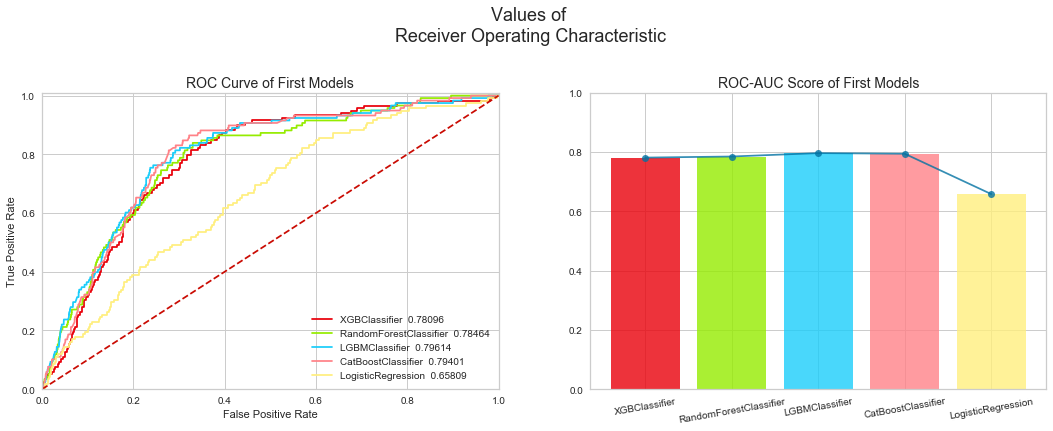

In [66]:
# Plot of ROC Score for all models

# Figure size-title for Plot 
fig, ax = plt.subplots(1, 2, figsize=(18,12))
fig.suptitle('Values of\n Receiver Operating Characteristic', fontsize=18)

# Plot for ROC Curve of first Models
plt.subplot(221).set_title('ROC Curve of First Models', size=14)
color=['#E9000A','#95EC00','#1BCDFA','#FF8288','#FFEF7E']; i=0
for model in models_BP:
    col = color[i]; i+=1
    preds = model.predict_proba(X_test)[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=type(model).__name__+'  '+str(round(roc_auc,5)), color=col)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

# Plot for ROC-AUC Score of First Models
plt.subplot(222).set_title('ROC-AUC Score of First Models', size=14)
Model_title = list(first_model_roc.keys())
fmr= list(first_model_roc.values())
y_pos = np.arange(len(Model_title))
plt.ylim([0.0, 1])
plt.bar(y_pos, fmr, alpha=0.8, color=color)
plt.plot(Model_title, fmr,'bo-', alpha=0.8) 
plt.xticks(Model_title, rotation=10);

# 5. Improving of Models
In this section, the **Synthetic** data will be created.

**Purpose:** <br>
I will create synthetic data to fix the **IMBALANCE** problem in the **`Mailout-Train`** dataset. For this, I will use **`Azdias`** and **`Customers`** datasets. **Synthetic** data set will include **`Mailout-Train`**, **`Azdias`**, and **`Customers`** data.
I will increase the number of records of dataset. (**RESPONSE** = 1 ratio will be ~30%) to enter train.
In this action:
- General population data **`Azdias`** 5%
- General Customer Data **`Customers`** 20%
- **`Mailout-Train`** dataset will be taken 100%.

Besides, I will use some of these synthetic data we created for Control. The data that I created for Train and Control (**RESPONSE** = 1 ratio will be ~30%).

<img src="https://github.com/huseyinelci2000/CustomerSegmentation/blob/master/Last/image/Azdias_01.jpg?raw=true" width="100%">

<a id="1"></a>
## 5.1. Loading of Datas

In [45]:
use_colab=0  # When you want to use COLAB, assign 1 to use_colab
if use_colab==1:
    # Files with Path of Data from Colab
    attribute_file = '../content/drive/My Drive/Studying_Data/Last/data/DIAS Attributes - Values 2017.xlsx'
    train_file = '../content/drive/My Drive/Studying_Data/Last/data/mailout_train'
    test_file = '../content/drive/My Drive/Studying_Data/Last/data/mailout_test'
    azdias_file = '../content/drive/My Drive/Studying_Data/Last/data/azdias.csv'
    customer_file = '../content/drive/My Drive/Studying_Data/Last/data/customers.csv'
else:
    # Use data from My Local
    # Files with PATH
    attribute_file = '../Last/data/DIAS Attributes - Values 2017.xlsx'
    train_file = '../Last/data/mailout_train'
    test_file = '../Last/data/mailout_test'
    azdias_file = '../Last/data/azdias.csv'
    customer_file = '../Last/data/customers.csv'

In [46]:
# Loading of Azdias and Customers datasets
azdias = pd.read_csv(azdias_file,
                     na_values=['X','XX', -1],
                     index_col=0)
customers = pd.read_csv(customer_file,
                        na_values=['X','XX', -1],
                        index_col=0)


# Loading of Maılout-Train and Mailout-Test datasets
train    = pd.read_csv(train_file, 
                        na_values=['X','XX', -1],
                        index_col=0)
test = pd.read_csv(test_file, 
                        na_values=['X','XX', -1], 
                        index_col=0)
azdias.set_index('LNR',inplace=True)
customers.set_index('LNR',inplace=True)
train.set_index('LNR',inplace=True)
test.set_index('LNR',inplace=True)

In [47]:
print('Shape of Azdias data...:', azdias.shape)
print('Shape of Customers data:',customers.shape)
print('Shape of Train data....:',train.shape)
print('Shape of Test data.....:',test.shape)

Shape of Azdias data...: (891221, 365)
Shape of Customers data: (191652, 368)
Shape of Train data....: (42962, 366)
Shape of Test data.....: (42833, 365)


---
<a id="2"></a>
## 5.2. Preprocesing the data

In [48]:
# Synchronizing of Dataframes
drop(customers,col_sync(customers,azdias))


# Pre-Processing for Syntetic Data
azdias['RESPONSE'] = 0
customers['RESPONSE'] = 1
test['RESPONSE']=0
response = train[['RESPONSE']]
print('Shape of Azdias data...:', azdias.shape)
print('Shape of Customers data:',customers.shape)
print('Shape of Train data....:',train.shape)
print('Shape of Test data.....:',test.shape)

Shape of Azdias data...: (891221, 366)
Shape of Customers data: (191652, 366)
Shape of Train data....: (42962, 366)
Shape of Test data.....: (42833, 366)


In [49]:
azdias['Table'] = 'Azdias_Control'
customers['Table'] = 'Customers'
train['Table'] = 'Train'
test['Table'] = 'Test'

#### Choosing of sample the Azdias and Customers data set for synthetic data.

In [50]:
azdias_sample = azdias.sample(frac =.05)                  #44561
customers_sample = customers.sample(frac =.20)            #38330

In [51]:
print('Shape of Azdias Sample data...:', azdias_sample.shape)
print('Shape of Customers Sample data:',customers_sample.shape)
print('Shape of Train data....:',train.shape)
print('Shape of Test data.....:',test.shape)

Shape of Azdias Sample data...: (44561, 367)
Shape of Customers Sample data: (38330, 367)
Shape of Train data....: (42962, 367)
Shape of Test data.....: (42833, 367)


In [52]:
# Checking if the features are the same
set(azdias_sample.columns.tolist())==set(
    customers_sample.columns.tolist())==set(
    train.columns.tolist())==set(
    test.columns.tolist())

True

#### Choosing of sample Customers data set for Control data.

In [53]:
# Selecting samples for Control in customers_sample
customers_sample['Table'][customers_sample['Table'].sample(frac=0.5, random_state=seed).index]='Customer_Control'

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Merging of chosen of sample datasets

In [54]:
# Merge of azdias_sample, customers_sample_train and test datasets 

df_union = pd.concat([azdias_sample, customers_sample, train, test])

In [55]:
df_union.drop_duplicates(inplace=True, keep='first')
df_union.shape

(146787, 367)

In [56]:
# Demographic of df_union after drop_duplicate
df_union.groupby(['Table','RESPONSE'])[['Table']].count()

Table
Table            RESPONSE       
Azdias_Control   0         42266
Customer_Control 1         15118
Customers        1         15003
Test             0         37200
Train            0         36727
                 1           473

In [57]:
table = df_union[['Table']]
del df_union['Table']

#### The process of extracting important columns
I have determined **important features** with transactions in **Part1** and **Part2** and I use these in Synthetic data set.

In [58]:
# Loading important columns comes from Part-2-UnsupervisedLearing
imp_feat_list = list(pd.read_csv('../Last/imp_feat_list_part2.csv', index_col=0).index.values[0:70])

if 'customer' in imp_feat_list:
    imp_feat_list.remove('customer')
# Length of important columns list
print('Size of important columns comes from Part-2-UnsupervisedLearing:',len(imp_feat_list))

Size of important columns comes from Part-2-UnsupervisedLearing: 55


#### Preprocessing of  Synthetic data set

In [59]:
df_union_pre, df_union_col = pre_processing(df_union, attribute_file, 0.8, imp_feat_list)

Start Preprocessing...
 Implementing of Cols-Drop
 processing of get_dummies ...
 Processing of fill NaN with MEAN...
 Processing of scaling...


In [60]:
df_union_pre[['Table']] = table

#### Label Encoding of RESPONCE feature

In [61]:
# Looking for RESPONSE column
display(df_union_pre['RESPONSE'].value_counts())

# Label  Encoding for RESPONSE column
df_union_pre['RESPONSE'].replace({df_union_pre['RESPONSE'].unique().tolist()[0]:0,
                                df_union_pre['RESPONSE'].unique().tolist()[1]:1}, inplace=True)
df_union_pre['RESPONSE'].value_counts()

-0.513131    116193
 1.948821     30594
Name: RESPONSE, dtype: int64

0.0    116193
1.0     30594
Name: RESPONSE, dtype: int64

## 5.3. Saving Union Synthetic Dataset

In [62]:
# Saving  New Synthetic Data (with pre-processing)
df_union_pre.to_csv('df_union_pre.csv')

### Preparation of data sets before Models implementing

#### Loading Union Synthetic Dataset

In [67]:
df_union_pre = pd.read_csv('df_union_pre.csv',
                           na_values=['X','XX', -1],
                           index_col=0)

#### Train-Test-Train Control Split of Union Synthetic Dataset

* **`df_train`** :This dataset contains the synthetic data create for training.<br>
* **`df_test`** :This dataset contains the Mailout-Test records.<br>
* **`df_train_control`** :This data set contains real customer records from Customers dataset used for estimation after training.

In [68]:
df_train = df_union_pre[(df_union_pre['Table']=='Customers') | (df_union_pre['Table']=='Train')]
df_test = df_union_pre[(df_union_pre['Table']=='Test')]
df_train_control = df_union_pre[(df_union_pre['Table']=='Azdias_Control') | (df_union_pre['Table']=='Customer_Control')] 

### Some the numbers of New Sythetic Mixed Mailout Data

#### Distrubution of df_train set

In [69]:
df_train_stat = pd.concat([df_train['Table'].value_counts(),
        df_train['Table'].value_counts()/df_train['Table'].value_counts().sum()],
        axis=1)

df_train_stat.columns=['Count','Count_Percent']
print('Distrubution of Train after create syntetic data')
display(df_train_stat)

Distrubution of Train after create syntetic data


,Count,Count_Percent
Train,37200,0.712603
Customers,15003,0.287397


#### Distrubution of df_test set

In [70]:
df_test['Table'].value_counts()


df_test_stat = pd.concat([df_test['Table'].value_counts(),
        df_test['Table'].value_counts()/df_test['Table'].value_counts().sum()],
        axis=1)

df_test_stat.columns=['Count','Count_Percent']
print('Distrubution of Test')
display(df_test_stat)

Distrubution of Test


,Count,Count_Percent
Test,37200,1.0


#### Distrubution of df_train_control set

In [71]:
df_train_control_stat = pd.concat([df_train_control['Table'].value_counts(),
        df_train_control['Table'].value_counts()/df_train_control['Table'].value_counts().sum()],
                                axis=1)

df_train_control_stat.columns=['Count','Count_Percent']
print('Distrubution of Control Data after create syntetic data')
display(df_train_control_stat)

Distrubution of Control Data after create syntetic data


,Count,Count_Percent
Azdias_Control,42266,0.736547
Customer_Control,15118,0.263453


#### Drop Some Columns

In [72]:
del df_train['Table']
df_test.drop(['Table','RESPONSE'], axis=1, inplace=True)
del df_train_control['Table']

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### Plot and Some the number of Synthetic data 

Total number of records ......................: 52203
Individuals who became customers .............: 15476
Individuals who did not become customers .....: 36727
Percentage of individuals who became customers: 29.646%


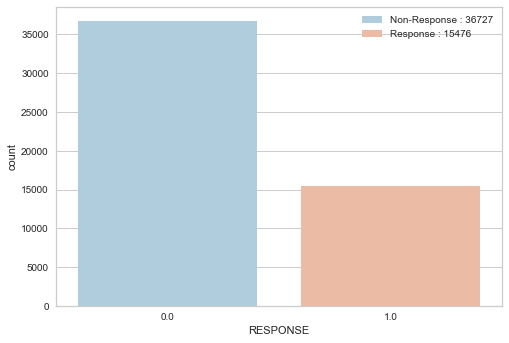

In [73]:
# Total number of records
num_records = df_train.shape[0]

# Number of records where the individual became a customer
num_customer = df_train[df_train['RESPONSE'] == 1].shape[0]

# Number of records where individual did not become a customer
num_not_customer = df_train[df_train['RESPONSE'] == 0].shape[0]

# Percentage of individuals who became customers
perc_customer = (num_customer / num_records) * 100

# Print the results
print("Total number of records ......................: {}".format(num_records))
print("Individuals who became customers .............: {}".format(num_customer))
print("Individuals who did not become customers .....: {}".format(num_not_customer))
print("Percentage of individuals who became customers: {}%".format(round(perc_customer,3)))

# Plotting
sns.countplot(x="RESPONSE",
              hue="RESPONSE",
              data=df_train,
              dodge=False,
              palette="RdBu_r")

plt.legend({"Non-Response : {}".format(num_not_customer):0,
            "Response : {}".format(num_customer):1});

---

## 5.4. Modeling

---

## Train-Test Split with New Synthetic Data

In [74]:
y = df_train['RESPONSE'].values                # Target Value as array
X = df_train.drop('RESPONSE', axis=1).values   # Features as array

# Train - Test - Split Data 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=seed)

In [75]:
y_train_control = df_train_control['RESPONSE'].values                # Target Value as array
X_train_control = df_train_control.drop('RESPONSE', axis=1).values   # Features as array



## Lightgbm
Let's try with **Lightgbm** to see if can improve the score.

##### With Default Parameters

In [76]:
lgb = LGBMClassifier(random_state = seed)
accu_cm(lgb,  X_train, y_train, X_test, y_test)

════════════════════════════════════════════════════════════
Model Name      : LGBMClassifier
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.8063101647570434
Accurarcy Score :  0.7672209026128266
Confusion Matrix:
 [[8182 1000]
 [2038 1831]]


##### Model Tuning

In [ ]:
grid_params = {
        'random_state': [seed],
        'n_estimators': [10,15,20],
        'n_jobs': [-1],
        'ntrees': [40],
        'learn_rate' : np.arange(0.01,0.2,0.005),
        'sample_rate':[0.45], 
        'col_sample_rate_per_tree': [0.8],
        'stopping_metric':['AUC'],
        'min_rows':[3],
        'min_child_samples':[40,60,100],
        'max_depth': [8],
        'max_features':[3],
        'class_weight': ['balanced']
}

In [77]:
try: 
    # After Sampling
    clf_LGB = GridSearchCV(LGBMClassifier(), grid_params, cv=5)
    clf_LGB.fit(X_train, y_train)
except:
    print('OOPSS.. Something wrong')
    pass

printS(clf_LGB)

════════════════════════════════════════════════════════════
For GridSearchCV model 
Best Score: 0.7697436539750244
════════════════════════════════════════════════════════════
Best Params: 
 {'C': 0.015, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'penalty': 'l2', 'random_state': 29, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0}


In [78]:
# Computation of Scores and CM with Best Parameters
best_params_LGB = clf_LGB.best_params_
lgb_BP = LGBMClassifier(**best_params_LGB)
accu_cm(lgb_BP, X_train, y_train, X_test, y_test) 

════════════════════════════════════════════════════════════
Model Name      : LGBMClassifier
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.8063101647570434
Accurarcy Score :  0.7672209026128266
Confusion Matrix:
 [[8182 1000]
 [2038 1831]]


In [79]:
# Computation of Scores and CM with My Best Parameters
lgb_BP_my = LGBMClassifier(random_state= seed)

# accu_cum function for X_test - y_test
print('For Test data')
accu_cm(lgb_BP_my, X_train, y_train, X_test, y_test)
print('')
# accu_cum function for Control_X_test - Control_y_test
print('For Train Control data')
accu_cm(lgb_BP_my, X_train, y_train, X_train_control, y_train_control)

For Test data
════════════════════════════════════════════════════════════
Model Name      : LGBMClassifier
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.8063101647570434
Accurarcy Score :  0.7672209026128266
Confusion Matrix:
 [[8182 1000]
 [2038 1831]]

For Train Control data
════════════════════════════════════════════════════════════
Model Name      : LGBMClassifier
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.7341164520206778
Accurarcy Score :  0.7502091175240485
Confusion Matrix:
 [[35591  6675]
 [ 7659  7459]]


---

## XGBoost
Let's try with **XGBoost** to see if can improve the score.

##### With Default Parameters

In [80]:
XGB = XGBClassifier(random_state = seed)
accu_cm(XGB, X_train, y_train, X_test, y_test)

════════════════════════════════════════════════════════════
Model Name      : XGBClassifier
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.7951991233930613
Accurarcy Score :  0.7585625622557658
Confusion Matrix:
 [[8041 1141]
 [2010 1859]]


##### Model Tuning

In [81]:
grid_params = {
    'random_state':[seed],
    'n_jobs':[-1],
    'reg_alpha':[0.1],
    'min_child_weight':[1,2],
    'max_depth':[8,13],
    'learning_rate':[0.1,0.15,0.2],
    'subsample':[0.8],
    'colsample_bytree':[0.6,0.7],
    'nthread':[5]
}

In [82]:
try:
    # After Sampling
    clf_XGB = GridSearchCV(XGBClassifier(), grid_params, cv=5)
    clf_XGB.fit(X_train, y_train)
except:
    print('OOPSS.. Something wrong')
    pass

printS(clf_XGB)

════════════════════════════════════════════════════════════
For GridSearchCV model 
Best Score: 0.7704587410320153
════════════════════════════════════════════════════════════
Best Params: 
 {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 2, 'n_jobs': -1, 'nthread': 5, 'random_state': 29, 'reg_alpha': 0.1, 'subsample': 0.8}


In [83]:
# Computation of Scores and CM with Best Parameters
best_params_XGB = clf_XGB.best_params_
XGB_BP = XGBClassifier(**best_params_XGB)

# accu_cum function for X_test - y_test
print('For Test data')
accu_cm(XGB_BP,  X_train, y_train, X_test, y_test)
print('')
# accu_cum function for Control_X_test - Control_y_test
print('For Train Control data')
accu_cm(XGB_BP,  X_train, y_train, X_train_control, y_train_control)

For Test data
════════════════════════════════════════════════════════════
Model Name      : XGBClassifier
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.8047121282331805
Accurarcy Score :  0.7642326258524251
Confusion Matrix:
 [[8137 1045]
 [2032 1837]]

For Train Control data
════════════════════════════════════════════════════════════
Model Name      : XGBClassifier
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.7294382692615721
Accurarcy Score :  0.7465495608531995
Confusion Matrix:
 [[35335  6931]
 [ 7613  7505]]


---

# CatBoost
Let's try with **CatBoost** to see if can improve the score.

##### With Default Parameters 

In [84]:
Cat = CatBoostClassifier(random_state = seed,verbose=False)
accu_cm(Cat,  X_train, y_train, X_test, y_test)

════════════════════════════════════════════════════════════
Model Name      : CatBoostClassifier
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.8077381668506584
Accurarcy Score :  0.7643858708144969
Confusion Matrix:
 [[8138 1044]
 [2031 1838]]


##### Model Tuning
[Detail Source](https://catboost.ai/docs/concepts/python-reference_parameters-list.html#python-reference_parameters-list)

In [85]:
grid_params = {
    'random_state':[seed],
    'num_trees':[4],
    'min_child_samples':[20, 30],
    'one_hot_max_size':[4],
    'learning_rate':[0.0925, 0.15],
    'border_count':[82],
    'eval_metric':['AUC'],
    'verbose':[0]
}

In [86]:
try:
    # Before Sampling
    clf_Cat = GridSearchCV(CatBoostClassifier(), grid_params, cv=5)
    clf_Cat.fit(X_train, y_train)
except:
    print('OOPSS.. Something wrong')
    pass

printS(clf_Cat)

════════════════════════════════════════════════════════════
For GridSearchCV model 
Best Score: 0.7486207565210995
════════════════════════════════════════════════════════════
Best Params: 
 {'border_count': 82, 'eval_metric': 'AUC', 'learning_rate': 0.15, 'min_child_samples': 20, 'num_trees': 4, 'one_hot_max_size': 4, 'random_state': 29, 'verbose': 0}


In [87]:
# Computation of Scores and CM with Best Parameters
best_params_Cat = clf_Cat.best_params_
Cat_BP = CatBoostClassifier(**best_params_Cat)
accu_cm(Cat_BP, X_train, y_train, X_test, y_test) 

════════════════════════════════════════════════════════════
Model Name      : CatBoostClassifier
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.7798429355331791
Accurarcy Score :  0.7530457436211785
Confusion Matrix:
 [[8174 1008]
 [2215 1654]]


In [92]:
# Computation of Scores and CM with My Best Parameters
best_params_Cat_my ={'random_state':seed,
                     'learning_rate':0.0045,
                     'eval_metric':'AUC',
                     'verbose':0}
Cat_BP_my = CatBoostClassifier(**best_params_Cat_my)

# accu_cm function for X_test - y_test
accu_cm(Cat_BP_my, X_train, y_train, X_test, y_test)
print('')
# accu_cm function for Control_X_test - Control_y_test
print('For Train Control data')
accu_cm(Cat_BP_my, X_train, y_train, X_train_control, y_train_control)

════════════════════════════════════════════════════════════
Model Name      : CatBoostClassifier
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.8023965157311896
Accurarcy Score :  0.7657650754731439
Confusion Matrix:
 [[8355  827]
 [2230 1639]]

For Train Control data
════════════════════════════════════════════════════════════
Model Name      : CatBoostClassifier
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.7339111082910496
Accurarcy Score :  0.7784922626516102
Confusion Matrix:
 [[38119  4147]
 [ 8564  6554]]


---

# Random Forest
Let's try with **RandomForest** to see if can improve the score.

##### With Default Parameters

In [93]:
RandF = RandomForestClassifier(random_state = seed)
accu_cm(RandF, X_train, y_train, X_test, y_test)

════════════════════════════════════════════════════════════
Model Name      : RandomForestClassifier
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.7890723103891615
Accurarcy Score :  0.7608612366868439
Confusion Matrix:
 [[8320  862]
 [2259 1610]]


##### Model Tuning
[Detail Source](https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6)

In [94]:
grid_params = {
    'random_state':[seed],
    'n_estimators':[20,40],
    'max_depth':[6,8],
    'max_features':[13],
    'min_samples_split':[4]
}

In [95]:
try:
    # Before Sampling
    clf_RandF = GridSearchCV(RandomForestClassifier(), grid_params, cv=5)
    clf_RandF.fit(X_train, y_train)
except:
    print('OOPSS.. Something wrong')
    pass

printS(clf_RandF)

════════════════════════════════════════════════════════════
For GridSearchCV model 
Best Score: 0.7592205357330699
════════════════════════════════════════════════════════════
Best Params: 
 {'max_depth': 8, 'max_features': 13, 'min_samples_split': 4, 'n_estimators': 40, 'random_state': 29}


In [96]:
# Computation of Scores and CM with Best Parameters
best_params_RandF = clf_RandF.best_params_
RandF_BP = RandomForestClassifier(**best_params_RandF)


# accu_cm function for X_test - y_test
accu_cm(RandF_BP, X_train, y_train, X_test, y_test)
print('')
# accu_cm function for Control_X_test - Control_y_test
print('For Train Control data')
accu_cm(RandF_BP, X_train, y_train, X_train_control, y_train_control)

════════════════════════════════════════════════════════════
Model Name      : RandomForestClassifier
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.795933222872647
Accurarcy Score :  0.7612443490920237
Confusion Matrix:
 [[8303  879]
 [2237 1632]]

For Train Control data
════════════════════════════════════════════════════════════
Model Name      : RandomForestClassifier
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.7533341477179158
Accurarcy Score :  0.7962149728147219
Confusion Matrix:
 [[39326  2940]
 [ 8754  6364]]


---

# Logistic Regression
Let's try with **Logistic Regression** to see if can improve the score.

##### With Default Parameters

In [97]:
LogReg = LogisticRegression(random_state = seed)
accu_cm(LogReg, X_train, y_train, X_test, y_test)

════════════════════════════════════════════════════════════
Model Name      : LogisticRegression
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.7507678924327373
Accurarcy Score :  0.7364952877174162
Confusion Matrix:
 [[8249  933]
 [2506 1363]]


##### Model Tuning

In [98]:
grid_params = {'C': [0.2, 1.0,3.0],
               'max_iter': [100, 150],
               'random_state': [seed],
               'tol': [0.0001],
               'verbose': [0]}

In [99]:
try:
    # Before Sampling
    clf_LogReg = GridSearchCV(LogReg, grid_params, cv=5, verbose=False)
    clf_LogReg.fit(X_train, y_train)
except:
    print('OOPSS.. Something wrong')
    pass

printS(clf_LogReg)

════════════════════════════════════════════════════════════
For GridSearchCV model 
Best Score: 0.7406007397980943
════════════════════════════════════════════════════════════
Best Params: 
 {'C': 0.2, 'max_iter': 100, 'random_state': 29, 'tol': 0.0001, 'verbose': 0}


In [100]:
# Computation of Scores and CM with Best Parameters
best_params_LogReg = clf_LogReg.best_params_
LogReg_BP = LogisticRegression(**best_params_LogReg)
accu_cm(LogReg_BP, X_train, y_train, X_test, y_test) 

════════════════════════════════════════════════════════════
Model Name      : LogisticRegression
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.7507817136239056
Accurarcy Score :  0.7367251551605241
Confusion Matrix:
 [[8252  930]
 [2506 1363]]


# Second Results of Modelling  (about New Sythetic Datas)
The **ROC-AUS Score** and **CM** were calculate for New Sythetic Data Sets and that results are below:

In [104]:
# All result of ROC-AUC Score
#models_BP = [XGB_BP, RandF_BP, lgb_BP, Cat_BP, LogReg_BP]
models_BP = [XGB_BP, RandF_BP, Cat_BP_my, lgb_BP_my, LogReg_BP ]

for model in models_BP:
    accu_cm(model,X_train, y_train, X_test, y_test)

════════════════════════════════════════════════════════════
Model Name      : XGBClassifier
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.8047121282331805
Accurarcy Score :  0.7642326258524251
Confusion Matrix:
 [[8137 1045]
 [2032 1837]]
════════════════════════════════════════════════════════════
Model Name      : RandomForestClassifier
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.795933222872647
Accurarcy Score :  0.7612443490920237
Confusion Matrix:
 [[8303  879]
 [2237 1632]]
════════════════════════════════════════════════════════════
Model Name      : CatBoostClassifier
════════════════════════════════════════════════════════════
ROC-AUC Score   :  0.8023965157311896
Accurarcy Score :  0.7657650754731439
Confusion Matrix:
 [[8355  827]
 [2230 1639]]
════════════════════════════════════════════════════════════
Model Name      : LGBMClassifier
════════════════════════════════════════════════════════════
ROC-

#### Plot of ROC Score for all models

In [105]:
# All result of ROC-AUC Score
#models_BP = [XGB_BP, RandF_BP, lgb_BP, Cat_BP, LogReg_BP]
models_BP = [XGB_BP, RandF_BP, Cat_BP_my, lgb_BP_my, LogReg_BP ]

second_model_roc={}
second_model_roc_control={}
for model in models_BP:
    # Fitting
    model.fit(X_train, y_train)
    
    # Evaluating
    score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    second_model_roc[type(model).__name__] = roc_auc_score(y_test,
                                        model.predict_proba(X_test)[:,1])
    second_model_roc_control[type(model).__name__] = roc_auc_score(y_train_control,
                                        model.predict_proba(X_train_control)[:,1])
    #second_model_roc[type(model).__name__] = ROC_AUC_score(model, X_train, y_train, X_test, y_test)
    #second_model_roc_control[type(model).__name__] = ROC_AUC_score(model,
    #                                                               X_train, y_train, 
    #                                                               X_train_control, y_train_control);

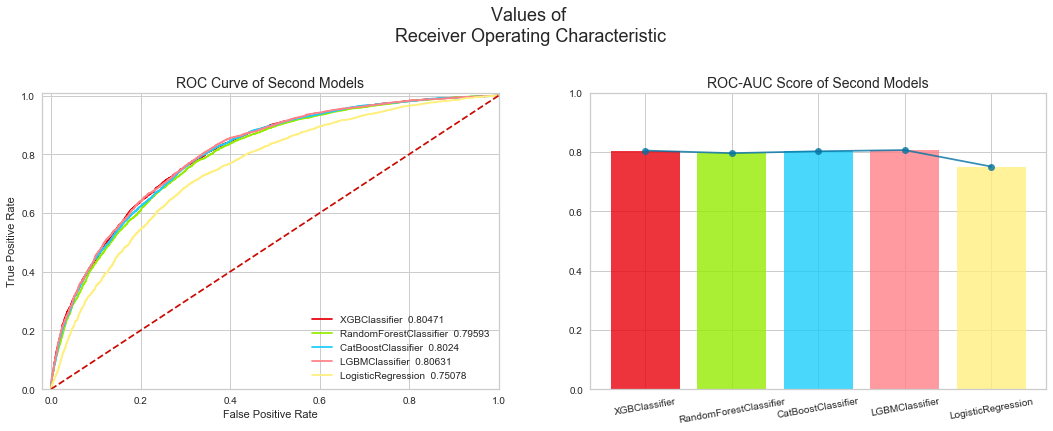

In [106]:
#Plot of ROC Score

# Figure size-title for Plot 
fig, ax = plt.subplots(1, 2, figsize=(18,12))
fig.suptitle('Values of\n Receiver Operating Characteristic', fontsize=18)
color=['#E9000A','#95EC00','#1BCDFA','#FF8288','#FFEF7E']; i=0

# Plot for ROC Curve of first Models
plt.subplot(221).set_title('ROC Curve of Second Models', size=14)
for model in models_BP:
    col = color[i]; i+=1
    y_preds = model.predict_proba(X_test)[:,1]
    fpr, tpr, threshold = roc_curve(y_test, y_preds)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=type(model).__name__+'  '+str(round(roc_auc,5)), color=col)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.01])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right");

# Plot for ROC-AUC Score of First Models
plt.subplot(222).set_title('ROC-AUC Score of Second Models', size=14)
Model_title = list(second_model_roc.keys())
predict_proba = list(second_model_roc.values())
y_pos = np.arange(len(Model_title))
plt.ylim([0.0, 1])
plt.bar(y_pos, predict_proba, alpha=0.8, color=color)
plt.plot(Model_title, predict_proba,'bo-', alpha=0.8) 
plt.xticks(Model_title, rotation=10);


##### Result:
The **ROC-AUS Score** calculated for the new **Synthetic Datasets** performed better than the previous raw dataset.

In [108]:
eclf = VotingClassifier(
    estimators = [('lgb_stack', lgb_BP_my),
                  ('xgb_stack', XGB_BP),
                  ('cat_stack', Cat_BP_my),
                  ('randf_stack', RandF_BP),
                  ('logreg_stack', LogReg_BP_my)
                 ],
    voting='soft', weights=[3,3,2,1,1], flatten_transform=True)

for clf, label in zip([lgb_BP_my, XGB_BP, Cat_BP_my, RandF_BP, LogReg_BP_my, eclf],
                      ['LGBM', 'XGBoost','CatBoost','RandomForest', 'LogisticRegression', 'Ensemble']):
    
    scores_accu = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    scores_roc = cross_val_score(clf, X, y, scoring='roc_auc', cv=5)
    scores_preci = cross_val_score(clf, X, y, scoring='precision', cv=5)
    print('='*50)
    print("Accuracy : %0.7f (+/- %0.2f) [%s]" % (scores_accu.mean(), scores_accu.std(), label))
    print("Roc-Auc  : %0.7f (+/- %0.2f) [%s]" % (scores_roc.mean(), scores_roc.std(), label))
    print("Precision: %0.7f (+/- %0.2f) [%s]" % (scores_preci.mean(), scores_preci.std(), label))
eclf_fit = eclf.fit(X,y)

Accuracy : 0.7687680 (+/- 0.00) [LGBM]
Roc-Auc  : 0.8118816 (+/- 0.00) [LGBM]
Precision: 0.6515052 (+/- 0.01) [LGBM]
Accuracy : 0.7689788 (+/- 0.00) [XGBoost]
Roc-Auc  : 0.8106768 (+/- 0.00) [XGBoost]
Precision: 0.6493213 (+/- 0.01) [XGBoost]
Accuracy : 0.7654540 (+/- 0.00) [CatBoost]
Roc-Auc  : 0.8062198 (+/- 0.00) [CatBoost]
Precision: 0.6629865 (+/- 0.01) [CatBoost]
Accuracy : 0.7591901 (+/- 0.00) [RandomForest]
Roc-Auc  : 0.7992634 (+/- 0.00) [RandomForest]
Precision: 0.6429199 (+/- 0.01) [RandomForest]
Accuracy : 0.7397084 (+/- 0.00) [LogisticRegression]
Roc-Auc  : 0.7517315 (+/- 0.01) [LogisticRegression]
Precision: 0.6050537 (+/- 0.01) [LogisticRegression]
Accuracy : 0.7690171 (+/- 0.00) [Ensemble]
Roc-Auc  : 0.8127248 (+/- 0.00) [Ensemble]
Precision: 0.6640793 (+/- 0.01) [Ensemble]


https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier.score

https://scikit-learn.org/stable/modules/ensemble.html#voting-classifierhttps://scikit-learn.org/stable/modules/ensemble.html#voting-classifier



https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation  sekil var

# Compare First and Second Results of Modelling

Hem **Azdias-Customers** hem de **Mailout.train-Mailout.test** datasetlerimizde **imbalance** problemi olduğunda **ROC-AUC Score**larını baz alacağımızı belirtmiştik. Buna göre **First** ve **Second** modellerimizin farklı Classifier lar için **ROC-AUC score** değerlerini karşılaştırdığımızda, _**en yüksek**_ değerlerin **`XGBoost Classifier`** ve **`CatBoost Classifier`** ile bulunduğunu görmekteyiz. 

In [119]:
eclf_roc_score = roc_auc_score(y_test,
                                eclf_fit.predict_proba(X_test)[:,1])
eclf_roc_score2 = roc_auc_score(y_train_control,
                                eclf_fit.predict_proba(X_train_control)[:,1])
eclf_roc = {'Second Model':{type(eclf).__name__:eclf_roc_score.mean()},
           'Second Model_Control':{type(eclf).__name__:eclf_roc_score2.mean()}}
eclf_df = pd.DataFrame(eclf_roc)
eclf_df.index.name='Name of ROC-AUC Score'

compare_roc = pd.concat([pd.DataFrame(first_model_roc.values(),
                                      index=list(first_model_roc.keys()),
                                      columns = ['First Model']),
                         pd.DataFrame(second_model_roc.values(),
                                      index=list(second_model_roc.keys()),
                                      columns = ['Second Model']),
                         pd.DataFrame(second_model_roc_control.values(),
                                      index=list(second_model_roc_control.keys()),
                                      columns = ['Second Model_Control'])
                         ], axis=1)

compare_roc.index.name='Name of ROC-AUC Score'
compare_roc = pd.concat([compare_roc,eclf_df], axis=0)
compare_roc.sort_values(by='Second Model', ascending=False)#.reset_index()

,First Model,Second Model,Second Model_Control
Name of ROC-AUC Score,,,
VotingClassifier,NaN,0.858809,0.727998
LGBMClassifier,0.796136,0.806310,0.734116
XGBClassifier,0.780960,0.804712,0.729438
CatBoostClassifier,0.794013,0.802397,0.733911
RandomForestClassifier,0.784644,0.795933,0.753334
LogisticRegression,0.658086,0.750782,0.672670


##### Result:
When I comparing First Model, Second Model, and Second Control, I saw **`VotingClassifier`** and **`LGBMClassifier`** will give us the best result. Because of that, the fine tuned **`VotingClassifier` will be used with the Mailout-Test** set.

### Step 2.3.3 Feature Importance

In [129]:
# Print score of important features of the model
imp_feat = pd.DataFrame({'Score of Important Feature':lgb_BP_my.feature_importances_,
                        '%':lgb_BP_my.feature_importances_/30}, index=imp_feat_list)
imp_feat_sorted = imp_feat.sort_values(by=['Score of Important Feature'], ascending=False)
imp_feat_sorted.head(10)

,Score of Important Feature,%
D19_SOZIALES,219,7.300000
EINGEZOGENAM_HH_JAHR,182,6.066667
ALTERSKATEGORIE_FEIN,140,4.666667
ALTER_HH,137,4.566667
VK_ZG11,135,4.500000
ANZ_STATISTISCHE_HAUSHALTE,112,3.733333
AKT_DAT_KL,103,3.433333
LP_LEBENSPHASE_FEIN,97,3.233333
RT_UEBERGROESSE,84,2.800000
VK_DISTANZ,74,2.466667


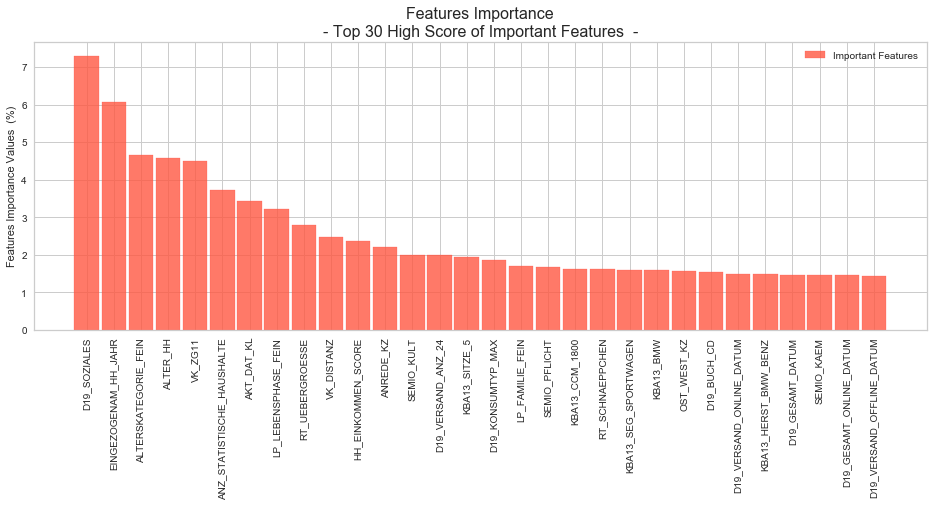

In [130]:
# Plot the most important features of the model
plt.figure(figsize=(16,8))

# Create data
height = imp_feat_sorted['%'].head(30)
bars = imp_feat_sorted.index[0:30]
y_pos = np.arange(len(bars))
 
# Create bar
plt.bar(y_pos, height, label='Important Features',
        edgecolor='#FF4842',width=0.9, color='#FF5842',
        alpha=0.8)

plt.ylabel("Features Importance Values  (%)")
plt.xticks(y_pos, bars, rotation=90,size = 10)
plt.title("Features Importance\n- Top 30 High Score of Important Features  -",
          size = 16)

plt.subplots_adjust(bottom=0.3)
plt.subplots_adjust(top=0.8);
plt.legend();

# Step 3.3 Classification of Mailout-Test data

Now, will done of **classification of Mailout-Test data** with best model trained on train data. In here, the fine tuned **`XGBoost model`** will be used on **Mailout-Test data.**

In [131]:
# Looking for Mailout-Test data
df_test.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,...,SEMIO_KULT,SEMIO_LUST,SEMIO_PFLICHT,SEMIO_TRADV,SEMIO_VERT,VK_DISTANZ,VK_ZG11,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
1754,-0.511620,-1.679882e+00,-1.090783,0.011635,-0.313292,-1.173745,-0.193266,0.780934,0.813845,0.777734,...,1.293922,1.019034,-1.441389,-1.308056,1.309281,0.181539,-0.335706,0.090126,-1.022803,0.752956
1770,-0.511620,4.677131e-16,-2.427643,-0.758804,1.058321,-0.366524,-0.193266,0.780934,0.813845,-0.049359,...,0.220108,-0.067232,-0.251269,-1.308056,0.798668,-0.993283,-1.053372,0.090126,-1.022803,0.752956
1465,2.405640,6.898094e-01,0.023267,1.552513,-0.313292,-0.366524,-0.193266,0.780934,0.813845,0.777734,...,-0.853707,1.019034,0.343791,-0.036104,-0.733170,0.181539,-0.335706,0.090126,0.977706,0.752956
1470,1.676325,4.677131e-16,-2.427643,-1.529243,-0.385482,-0.366524,-1.010528,0.780934,0.813845,0.777734,...,-0.853707,1.019034,-0.846329,-0.036104,-1.243782,0.181539,-0.335706,0.090126,0.977706,0.752956
1478,-0.511620,2.006305e+00,0.468887,1.552513,-0.385482,0.440698,-0.193266,-0.049135,0.022976,-0.049359,...,-0.853707,-0.067232,-0.251269,-0.036104,-0.733170,-0.405872,-0.335706,0.849295,0.977706,0.752956


In [132]:
# Predicting of Response from Mailout-Test set
df_test_response = eclf_fit.predict_proba(df_test.values)[:,1]
#df_test_response = XGB_BP.predict_proba(df_test.values)[:,1]

Created dataframe **`df_kaggle`** with two columns:
* The first column is a duplicate of **`LNR`**, which acts as an ID number for each individual in the **Mailout-Test** partition
* The second column, **`RESPONSE`**, is a measure of how likely each individual became a customer.

In [133]:
df_kaggle = pd.DataFrame({'LNR': df_test.index, 'RESPONSE': df_test_response})

In [140]:
# Generate CSV file for the Kaggle competition
df_kaggle.to_csv('../Last/data/kaggle_submission_file.csv', index=False)

In [134]:
# Label  Encoding for RESPONSE column
df_kaggle['RESPONSE_2'] = df_kaggle['RESPONSE'].apply(lambda x : 1 if x>=0.5 else 0)

df_kaggle.sample(10)

,LNR,RESPONSE,RESPONSE_2
4017,36464,0.103992,0
12478,51668,0.093551,0
25,11434,0.125693,0
3059,83792,0.038795,0
665,35062,0.246663,0
510,10566,0.095973,0
22548,57780,0.394969,0
2909,28825,0.196064,0
6390,77288,0.071212,0
31830,47673,0.644470,1


#### Plotting Result of Mailout-Test for all models

In [137]:
#Calculating of Mailout-Test Result for all models
models_BP.append(eclf_fit)
df_plot= pd.DataFrame()
for model in models_BP:
    df_test_response = model.predict_proba(df_test.values)[:,1]
    plot = pd.DataFrame({'LNR': df_test.index, type(model).__name__: df_test_response})
    plot[type(model).__name__] = plot[type(model).__name__].apply(lambda x : 1 if x>=0.5 else 0)
    a = {type(model).__name__:[plot[type(model).__name__].value_counts()[0],
                               plot[type(model).__name__].value_counts()[1]]}
    df_plot=pd.concat([df_plot,pd.DataFrame(a)], axis=1)


,XGBClassifier,RandomForestClassifier,CatBoostClassifier,LGBMClassifier,LogisticRegression,VotingClassifier
0,33013,33550,33724,33107,33579,33669
1,4187,3650,3476,4093,3621,3531


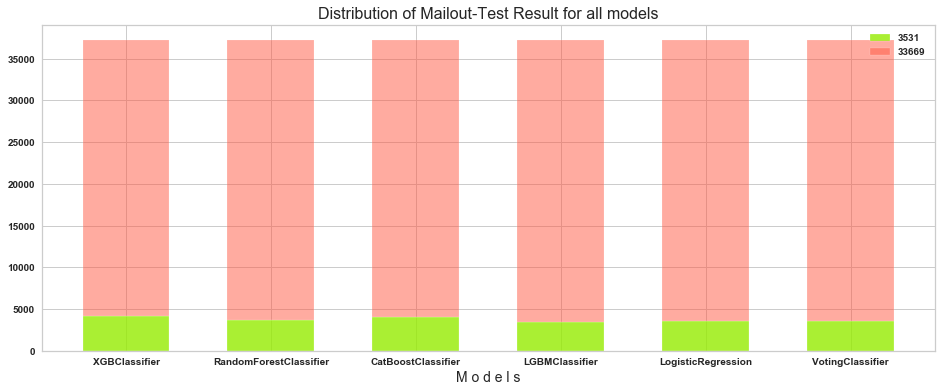

In [139]:
# Plot of Mailout-Test Result for all models

display(df_plot)

plt.figure(figsize=(16,6))
# y-axis in bold
rc('font', weight='bold')
 
# Values of each group
bars0 = [df_plot['XGBClassifier'][0],
         df_plot['RandomForestClassifier'][0],
         df_plot['LGBMClassifier'][0],
         df_plot['CatBoostClassifier'][0],
         df_plot['LogisticRegression'][0],
         df_plot['VotingClassifier'][0]]
            
bars1 = [df_plot['XGBClassifier'][1],
         df_plot['RandomForestClassifier'][1],
         df_plot['LGBMClassifier'][1],
         df_plot['CatBoostClassifier'][1],
         df_plot['LogisticRegression'][1],
         df_plot['VotingClassifier'][1]]
 
# Heights of bars1 + bars2
bars = np.add(bars1, bars0).tolist()
 
# The position of the bars on the x-axis
r = [0,1,2,3,4,5]
 
# Names of group and bar width
names = df_plot.columns
barWidth = 0.6
 
# Create bars (0)
plt.bar(r, bars1, color='#95EC00', edgecolor='white', width=barWidth, alpha=0.8)
# Create bars (1)
plt.bar(r, bars0, bottom=bars1, color='#FF5842', edgecolor='white', width=barWidth, alpha=0.5)

 
# Custom X axis
plt.xticks(r, names, fontweight='bold')
plt.xlabel("M o d e l s", size=14)
plt.title("Distribution of Mailout-Test Result for all models", size=16)
plt.legend([3531,33669]);

In [143]:
eclf_roc_score = roc_auc_score(y_test,
                                eclf_fit.predict_proba(X_test)[:,1])
eclf_roc_score2 = roc_auc_score(y_train_control,
                                eclf_fit.predict_proba(X_train_control)[:,1])
eclf_roc = {'Second Model':{type(eclf).__name__:eclf_roc_score.mean()},
           'Second Model_Control':{type(eclf).__name__:eclf_roc_score2.mean()}}
eclf_df = pd.DataFrame(eclf_roc)
eclf_df.index.name='Name of ROC-AUC Score'

In [144]:
eclf_df

,Second Model,Second Model_Control
Name of ROC-AUC Score,,
VotingClassifier,0.858809,0.727998
